In [1]:
# set variables and file paths

model_name = "meta-llama/Llama-3.3-70B-Instruct"
output_path_sample = "output/Llama_3.3_70B_zs_Debagree_3labels_sample.csv"


# **Llama-3.3-70B-Instruct**
## **Zero Shot Classification of 3 Labels (agree/disagree/neutral)**

* Ran on sample of 10.000 interactions
* Purpose: Compare two vs. three labels



In [2]:
# install packages
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install datasets 

In [3]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)


In [4]:
import torch
print(torch.cuda.is_available())
torch.cuda.empty_cache()

True


## **Authenticate for Hugging Face**

In [5]:
import os
os.getcwd()

'/home/jovyan/llama_final/Causal/three_label_debagree'

In [6]:
# Hugging face access
from huggingface_hub import login
with open("../../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

## **Data**

In [7]:
# loading the data

data = pd.read_csv("../../../data/debagree_new_preprocessing_com_rep.csv")
data = data[["label", "body_parent", "body_child", "msg_id_parent", "msg_id_child", "subreddit", "datetime", "exact_time"]].sort_values(by = "exact_time").reset_index(drop = True)

# keep integer labels
data['target'] = data['label']

# for readability, recode labels
int_to_label = {2: "agree", 1 : "neutral", 0 : "disagree"}
label_to_int = {"agree" : 2, "neutral" : 1, "disagree" : 0}
data.replace({"label": int_to_label}, inplace = True)

data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


### Sample interactions, keeping shares of subreddits and labels



In [8]:

def stratified_sample_target_size(df, subreddit_col, label_col, total_size):
    """
    Perform a two-level stratified sample:
    - First by subreddit (in proportion to their frequency)
    - Then by label within each subreddit (preserving label distribution)
    
    Returns exactly `total_size` rows.
    """
    # subreddit proportions
    subreddit_dist = df[subreddit_col].value_counts(normalize=True)

    sampled_rows = []

    for subreddit, subreddit_prop in subreddit_dist.items():
        # nr rows to sample from this subreddit
        subreddit_n = int(round(total_size * subreddit_prop))
        sub_df = df[df[subreddit_col] == subreddit]

        # within subreddit, keep label distribution
        label_dist = sub_df[label_col].value_counts(normalize=True)

        for label, label_prop in label_dist.items():
            label_n = int(round(subreddit_n * label_prop))
            label_df = sub_df[sub_df[label_col] == label]
            
            # Sample, but make sure we don't sample more than we have
            actual_n = min(label_n, len(label_df))
            if actual_n > 0:
                sampled_rows.append(label_df.sample(n=actual_n, random_state=42))

    # Combine all, shuffle, and trim to exactly `total_size`
    final_df = pd.concat(sampled_rows).sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure final size matches (if over, just trim)
    return final_df.iloc[:total_size]


In [9]:
sample_df = stratified_sample_target_size(data, "subreddit", "label", 10000)
sample_df

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,agree,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,gqak9tq,gqalvak,democrats,09/03/2021 04:29,1615264154,2
1,agree,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,ghrt3ay,ghw66nh,Republican,03/01/2021 03:02,1609642942,2
2,agree,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,gfask7y,gfav46i,Brexit,10/12/2020 17:23,1607620990,2
3,agree,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,gyj4rst,gyk1wwh,Republican,18/05/2021 11:30,1621337452,2
4,disagree,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,g7xuo23,g7y3wdy,Republican,06/10/2020 22:56,1602024961,0
...,...,...,...,...,...,...,...,...,...
9995,agree,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,fgdpkdc,fgdsys2,democrats,02/02/2020 23:35,1580686536,2
9996,neutral,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,gb4idfe,gb4ofe7,Republican,04/11/2020 16:28,1604507309,1
9997,agree,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,fogwj8w,foie0e3,Republican,25/04/2020 03:14,1587784461,2
9998,agree,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,g82yc73,g830mfp,Republican,08/10/2020 05:34,1602135247,2


## **Load the Model**


### Quantization for QLoRA

In [10]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

### **Load the Model**

* AutoModelForCausalLM 

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = quantization_config
)

model

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacity of 79.10 GiB of which 322.31 MiB is free. Process 309748 has 46.03 GiB memory in use. Process 342401 has 32.74 GiB memory in use. Of the allocated memory 31.62 GiB is allocated by PyTorch, and 549.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## **Tokenizer**

### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space = True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

### Update Model Configurations

In [31]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_pt = 1

## **Generate Prompts**

In [21]:
# make text


def create_training_data(data):

    result = []

    for idx, row in data.iterrows():
        system_prompt = """You are a classification chatbot. Analyze a Reddit comment and its reply. Determine whether the reply explicitly and unambiguously agrees, disagrees, or remains neutral toward the comment. Respond with "agree" for clear agreement, "disagree" for clear disagreement, or "neutral" if the reply adds information, qualifies the statement, offers an alternative perspective, is vague, off-topic, or leaves any doubt about agreement or disagreement. Your response must strictly be one of: "agree", "disagree", or "neutral"."""
        comment = row["body_parent"]
        reply = row["body_child"]
        label = row["label"]
        target = row["target"]
        
        comment_id = row["msg_id_parent"]
        reply_id = row["msg_id_child"]
        subreddit = row["subreddit"]
        
        result.append({'system_prompt' : system_prompt, 'comment' : comment, 'reply': reply, 'label' : label, 'target' : target, 'msg_id_parent' : comment_id, 'msg_id_child' : reply_id, 'subreddit' : subreddit})
    
    return result

# save data
df = pd.DataFrame(create_training_data(sample_df))
df

,system_prompt,comment,reply,label,target
0,You are a classification chatbot. Analyze a Re...,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,agree,2
1,You are a classification chatbot. Analyze a Re...,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,agree,2
2,You are a classification chatbot. Analyze a Re...,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,agree,2
3,You are a classification chatbot. Analyze a Re...,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,agree,2
4,You are a classification chatbot. Analyze a Re...,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,disagree,0
...,...,...,...,...,...
9995,You are a classification chatbot. Analyze a Re...,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,agree,2
9996,You are a classification chatbot. Analyze a Re...,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,neutral,1
9997,You are a classification chatbot. Analyze a Re...,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,agree,2
9998,You are a classification chatbot. Analyze a Re...,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,agree,2


In [22]:
 
def make_chat_prompt(row):

    temp = [] 
    temp.append({"role": "system", "content": row['system_prompt']})
    temp.append({"role": "user", "content": f"comment: '{row['comment']}' ; reply: '{row['reply']}'"})

    prompt = tokenizer.apply_chat_template(temp, tokenize=False, add_generation_prompt=True )
    
    return prompt

df['chat_prompt'] = df.apply(lambda row: make_chat_prompt(row), axis = 1)
df['chat_prompt'][0]

,system_prompt,comment,reply,label,target,sentence
0,You are a classification chatbot. Analyze a Re...,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
1,You are a classification chatbot. Analyze a Re...,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
2,You are a classification chatbot. Analyze a Re...,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
3,You are a classification chatbot. Analyze a Re...,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
4,You are a classification chatbot. Analyze a Re...,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,disagree,0,"[{'role': 'system', 'content': 'You are a clas..."
...,...,...,...,...,...,...
9995,You are a classification chatbot. Analyze a Re...,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
9996,You are a classification chatbot. Analyze a Re...,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,neutral,1,"[{'role': 'system', 'content': 'You are a clas..."
9997,You are a classification chatbot. Analyze a Re...,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."
9998,You are a classification chatbot. Analyze a Re...,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,agree,2,"[{'role': 'system', 'content': 'You are a clas..."


***

## **Apply model**

In [39]:

# Define batch size
batch_size = 32

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Function to process one prompt column
def generate_predictions(df, prompt_column_name, output_column_name):
    all_outputs = []

    # Get all prompts for the selected strategy
    prompts = df[prompt_column_name].tolist()

    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Generating for {prompt_column_name}"):
        batch_prompts = prompts[i:i + batch_size]

        # Tokenize (skip apply_chat_template here — it's already done)
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                num_return_sequences=1,
                do_sample=False  # Optional: make deterministic
            )

        # Decode and collect
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        all_outputs.extend(decoded)

    # Add raw output to the dataframe
    df[output_column_name] = all_outputs

    # Normalize and clean up (extract just 'agree' or 'disagree' if possible)
    df[output_column_name] = df[output_column_name].str.lower().str.strip()

    return df


100%|██████████| 313/313 [3:07:25<00:00, 35.93s/it]


,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target,predicted_labels
0,agree,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,gqak9tq,gqalvak,democrats,09/03/2021 04:29,1615264154,2,system\n\ncutting knowledge date: december 202...
1,agree,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,ghrt3ay,ghw66nh,Republican,03/01/2021 03:02,1609642942,2,system\n\ncutting knowledge date: december 202...
2,agree,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,gfask7y,gfav46i,Brexit,10/12/2020 17:23,1607620990,2,system\n\ncutting knowledge date: december 202...
3,agree,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,gyj4rst,gyk1wwh,Republican,18/05/2021 11:30,1621337452,2,system\n\ncutting knowledge date: december 202...
4,disagree,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,g7xuo23,g7y3wdy,Republican,06/10/2020 22:56,1602024961,0,system\n\ncutting knowledge date: december 202...
...,...,...,...,...,...,...,...,...,...,...
9995,agree,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,fgdpkdc,fgdsys2,democrats,02/02/2020 23:35,1580686536,2,system\n\ncutting knowledge date: december 202...
9996,neutral,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,gb4idfe,gb4ofe7,Republican,04/11/2020 16:28,1604507309,1,system\n\ncutting knowledge date: december 202...
9997,agree,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,fogwj8w,foie0e3,Republican,25/04/2020 03:14,1587784461,2,system\n\ncutting knowledge date: december 202...
9998,agree,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,g82yc73,g830mfp,Republican,08/10/2020 05:34,1602135247,2,system\n\ncutting knowledge date: december 202...


In [ ]:
# chat
df = generate_predictions(df, "chat_prompt", "predicted_chat")
df

### Preprocess Results

In [19]:
# Show the results

print(df['predicted_chat'][0])


system

cutting knowledge date: december 2023
today date: 26 jul 2024

you are a classification chatbot. analyze a reddit comment and its reply. determine if the reply explicitly and unambiguously disagrees with the comment. respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. your response must strictly be 'disagree' or 'no_disagreement'.user

comment: 'they shouldn't be winning elections, that's for sure, but i'm not sure how to angle a ban. all that would do is fail when it hit the supreme court and give them fuel for their martyr complex' ; reply: 'i agree with this. they obviously shouldn't be holding positions of power, but just outright banning an idea, even a horrible and dangerous one, just won't fly in the supreme court, especially not with the current justices. i think everyone agrees something should be done to get rid of white su

In [23]:
# extract
df['predicted_chat'] = df['predicted_chat'].apply(lambda x: x.split()[-1].strip("."))

df['predicted_chat'].value_counts()

predicted_chat
no_disagreement    7679
disagree           2321
Name: count, dtype: int64

In [24]:
df

,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,predicted_chat
0,You are a classification chatbot. Analyze a Re...,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,agree,2,gqak9tq,gqalvak,democrats,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
1,You are a classification chatbot. Analyze a Re...,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,agree,2,ghrt3ay,ghw66nh,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
2,You are a classification chatbot. Analyze a Re...,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,agree,2,gfask7y,gfav46i,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
3,You are a classification chatbot. Analyze a Re...,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,agree,2,gyj4rst,gyk1wwh,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
4,You are a classification chatbot. Analyze a Re...,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,disagree,0,g7xuo23,g7y3wdy,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
...,...,...,...,...,...,...,...,...,...,...
9995,You are a classification chatbot. Analyze a Re...,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,agree,2,fgdpkdc,fgdsys2,democrats,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
9996,You are a classification chatbot. Analyze a Re...,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,neutral,1,gb4idfe,gb4ofe7,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
9997,You are a classification chatbot. Analyze a Re...,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,agree,2,fogwj8w,foie0e3,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement
9998,You are a classification chatbot. Analyze a Re...,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,agree,2,g82yc73,g830mfp,Republican,<|begin_of_text|><|start_header_id|>system<|en...,no_disagreement


In [25]:
# recode to two labels
#df['label_2'] = df['label'].map(lambda x: 'no_disagreement' if x in ['neutral', 'agree'] else 'disagree')

#df.to_csv("output/Llama_3.3_70B_zs_Debagree_3labels_sample.csv", index = False)

In [42]:
sample_df[['msg_id_parent', 'msg_id_child', 'subreddit', 'label', 'predicted_labels']].to_csv(output_path_sample, index = False)


## **Reimport**

In [7]:
sample_df = pd.read_csv(output_path_sample)
sample_df['predicted_labels'] = sample_df['predicted_labels'].apply(lambda x: x.split()[-1])

sample_df

,msg_id_parent,msg_id_child,subreddit,label,predicted_labels
0,gqak9tq,gqalvak,democrats,agree,agree
1,ghrt3ay,ghw66nh,Republican,agree,neutral
2,gfask7y,gfav46i,Brexit,agree,agree
3,gyj4rst,gyk1wwh,Republican,agree,neutral
4,g7xuo23,g7y3wdy,Republican,disagree,disagree
...,...,...,...,...,...
9995,fgdpkdc,fgdsys2,democrats,agree,agree
9996,gb4idfe,gb4ofe7,Republican,neutral,does
9997,fogwj8w,foie0e3,Republican,agree,agree
9998,g82yc73,g830mfp,Republican,agree,agree


In [8]:
valid = sample_df[sample_df['predicted_labels'].isin(["agree", "disagree", "neutral"])].reset_index(drop = True)
valid

print(len(sample_df) - len(valid))

2067


## **Performance Analysis**

In [9]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predicted_labels

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [10]:
get_performance_metrics(valid)

Confusion Matrix:
[[1498  553  775]
 [ 206 2231  900]
 [ 255  463 1052]]

Classification Report:
              precision    recall  f1-score   support

       agree       0.76      0.53      0.63      2826
    disagree       0.69      0.67      0.68      3337
     neutral       0.39      0.59      0.47      1770

    accuracy                           0.60      7933
   macro avg       0.61      0.60      0.59      7933
weighted avg       0.65      0.60      0.61      7933

Balanced Accuracy Score: 0.5976642366660675
Accuracy Score: 0.6026723811924871


label
disagree    3337
agree       2826
neutral     1770
Name: count, dtype: int64


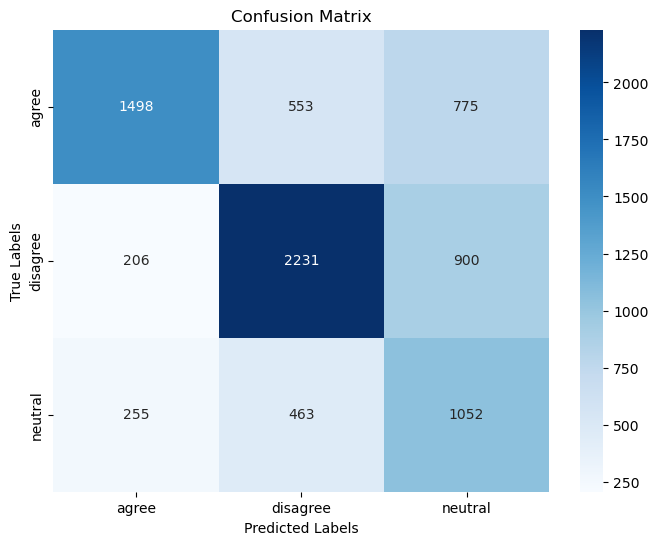

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns



print(valid['label'].value_counts())


cm = confusion_matrix(valid['label'], valid['predicted_labels'])
labels = sorted(set(valid['label']).union(set(valid['predicted_labels'])))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix")

plt.show()